## Nested Logit

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

%load_ext autoreload
%autoreload 2
import sys

import pymc as pm
import pytensor.tensor as pt

sys.path.append("../../../..")

%reload_ext autoreload
from pymc_marketing.customer_choice.nested_logit import NestedLogit

In [2]:
df = pd.read_csv("../../../../data/choice_wide_heating.csv")
df

,idcase,depvar,ic_gc,ic_gr,ic_ec,ic_er,ic_hp,oc_gc,oc_gr,oc_ec,oc_er,oc_hp,income,agehed,rooms,region
0,1,gc,866.00,962.64,859.90,995.76,1135.50,199.69,151.72,553.34,505.60,237.88,7,25,6,ncostl
1,2,gc,727.93,758.89,796.82,894.69,968.90,168.66,168.66,520.24,486.49,199.19,5,60,5,scostl
2,3,gc,599.48,783.05,719.86,900.11,1048.30,165.58,137.80,439.06,404.74,171.47,4,65,2,ncostl
3,4,er,835.17,793.06,761.25,831.04,1048.70,180.88,147.14,483.00,425.22,222.95,2,50,4,scostl
4,5,er,755.59,846.29,858.86,985.64,883.05,174.91,138.90,404.41,389.52,178.49,2,25,6,valley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,896,gc,766.39,877.71,751.59,869.78,942.70,142.61,136.21,474.48,420.65,203.00,6,20,4,mountn
896,897,gc,1128.50,1167.80,1047.60,1292.60,1297.10,207.40,213.77,705.36,551.61,243.76,7,45,7,scostl
897,898,gc,787.10,1055.20,842.79,1041.30,1064.80,175.05,141.63,478.86,448.61,254.51,5,60,7,scostl
898,899,gc,860.56,1081.30,799.76,1123.20,1218.20,211.04,151.31,495.20,401.56,246.48,5,50,6,scostl


## Single Layer Nesting

In [3]:
## No Fixed Covariates
utility_formulas = [
    "gc ~ ic_gc + oc_gc | ",
    "ec ~ ic_ec + oc_ec | ",
    "gr ~ ic_gr + oc_gr | ",
    "er ~ ic_er + oc_er | ",
    "hp ~ ic_hp + oc_hp | ",
]


nesting_structure = {"central": ["gc", "ec"], "room": ["hp", "gr", "er"]}


nstL_1 = NestedLogit(
    df,
    utility_formulas,
    "depvar",
    covariates=["ic", "oc"],
    nesting_structure=nesting_structure,
)
nstL_1

In [4]:
X, F, y = nstL_1.preprocess_model_data(df, utility_formulas)
print(X.shape)
F

(900, 5, 2)


In [5]:
coords = nstL_1.coords
coords

{'alts': ['gc', 'ec', 'gr', 'er', 'hp'],
 'alts_probs': ['gc', 'ec', 'gr', 'er'],
 'alt_covariates': ['ic', 'oc'],
 'fixed_covariates': [],
 'nests': ['central', 'room'],
 'obs': range(0, 900)}

In [6]:
nest_indices = nstL_1.nest_indices
nest_indices

{'top': {'central': array([0, 1]), 'room': array([2, 3, 4])}}

In [7]:
lambda_lkup = nstL_1.lambda_lkup
lambda_lkup

{'central': 0, 'room': 1}

In [8]:
alternatives = nstL_1.alternatives

In [9]:
nstL_1.make_model(X=X, W=F, y=y)

           alphas ~ Normal(0, 1)
            betas ~ Normal(0, 1)
     lambda_nests ~ Beta(2, 2)
                U ~ Deterministic(f(betas, alphas))
p_y_given_central ~ Deterministic(f(lambda_nests, betas, alphas))
        I_central ~ Deterministic(f(lambda_nests, betas, alphas))
   p_y_given_room ~ Deterministic(f(lambda_nests, betas, alphas))
           I_room ~ Deterministic(f(lambda_nests, betas, alphas))
        denom_top ~ Deterministic(f(lambda_nests, betas, alphas))
        P_central ~ Deterministic(f(lambda_nests, betas, alphas))
           P_room ~ Deterministic(f(lambda_nests, betas, alphas))
   prod_central_t ~ Deterministic(f(lambda_nests, betas, alphas))
      prod_room_t ~ Deterministic(f(lambda_nests, betas, alphas))
                p ~ Deterministic(f(lambda_nests, betas, alphas))
       likelihood ~ Categorical(p)

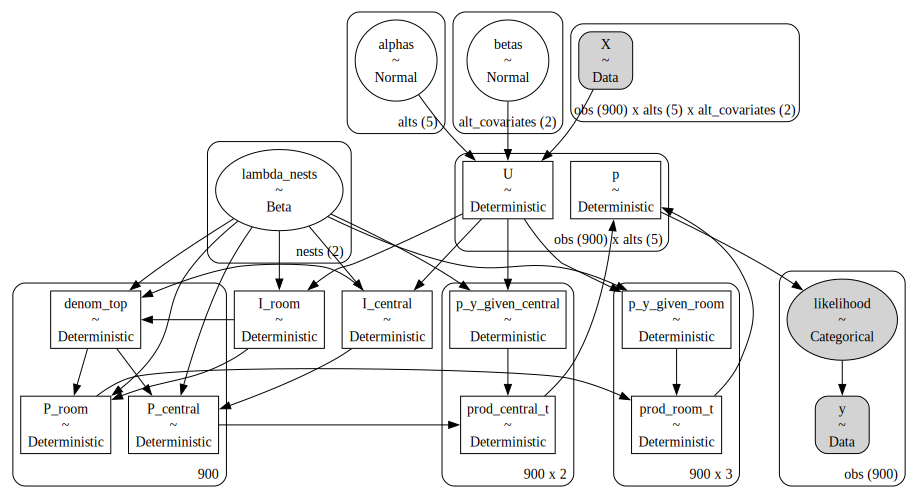

In [10]:
nstL_1.graphviz()

In [11]:
nstL_1.sample()

Sampling: [alphas, betas, lambda_nests, likelihood]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [likelihood]


Output()

In [12]:
az.summary(nstL_1.idata, var_names=["betas", "alphas", "lambda_nests"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[ic],-0.001,0.001,-0.002,-0.000,0.000,0.000,3218.0,2738.0,1.0
betas[oc],-0.005,0.001,-0.008,-0.003,0.000,0.000,1470.0,2041.0,1.0
alphas[gc],0.007,0.737,-1.378,1.356,0.018,0.013,1704.0,2152.0,1.0
alphas[ec],-0.007,0.722,-1.330,1.337,0.017,0.012,1787.0,2106.0,1.0
alphas[gr],0.080,0.138,-0.162,0.350,0.003,0.003,2596.0,2011.0,1.0
alphas[er],1.301,0.333,0.670,1.908,0.009,0.005,1485.0,1893.0,1.0
alphas[hp],0.012,1.021,-1.871,1.941,0.020,0.018,2646.0,2351.0,1.0
lambda_nests[central],0.749,0.125,0.521,0.968,0.004,0.002,1187.0,1693.0,1.0
lambda_nests[room],0.594,0.120,0.362,0.790,0.003,0.002,1209.0,1679.0,1.0


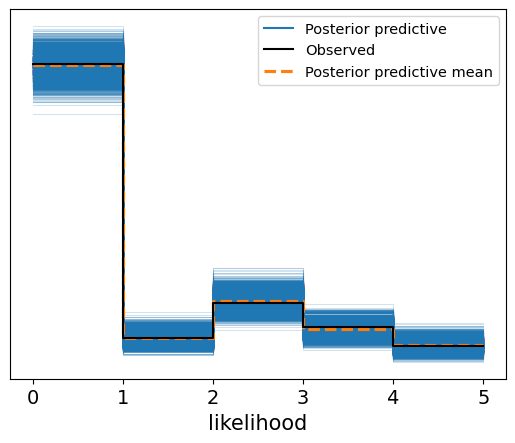

In [13]:
az.plot_ppc(nstL_1.idata);

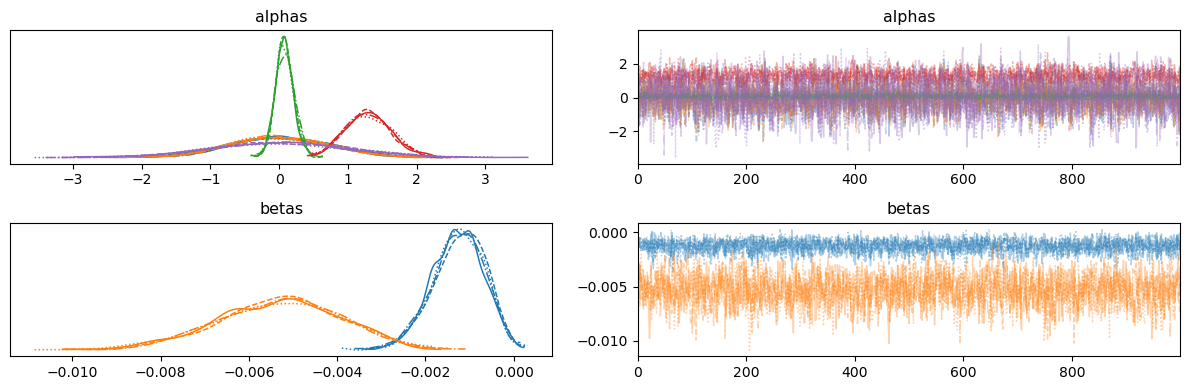

In [14]:
az.plot_trace(nstL_1.idata, var_names=["alphas", "betas"])
plt.tight_layout()

## Two Layer Nesting


In [15]:
## No fixed covariates
utility_formulas = [
    "gc ~ ic_gc + oc_gc | ",
    "ec ~ ic_ec + oc_ec | ",
    "gr ~ ic_gr + oc_gr | ",
    "er ~ ic_er + oc_er | ",
    "hp ~ ic_hp + oc_hp | ",
]


nesting_structure = {"central": ["gc", "ec"], "room": {"hp": ["hp"], "r": ["gr", "er"]}}

nstL_2 = NestedLogit(
    df,
    utility_formulas,
    "depvar",
    covariates=["ic", "oc"],
    nesting_structure=nesting_structure,
)
nstL_2

In [16]:
X, F, y = nstL_2.preprocess_model_data(df, utility_formulas)
print(X.shape)
F

(900, 5, 2)


In [17]:
coords = nstL_2.coords
coords

{'alts': ['gc', 'ec', 'gr', 'er', 'hp'],
 'alts_probs': ['gc', 'ec', 'gr', 'er'],
 'alt_covariates': ['ic', 'oc'],
 'fixed_covariates': [],
 'nests': ['central', 'room', 'room_hp', 'room_r'],
 'obs': range(0, 900)}

In [18]:
nest_indices = nstL_2.nest_indices
nest_indices

{'top': {'central': array([0, 1]), 'room': array([2, 3, 4])},
 'mid': {'room_hp': [4], 'room_r': [2, 3]}}

In [19]:
lambda_lkup = nstL_2.lambda_lkup
lambda_lkup

{'central': 0, 'room': 1, 'room_hp': 2, 'room_r': 3}

In [20]:
nstL_2.make_model(X, F, y)

                 alphas ~ Normal(0, 1)
                  betas ~ Normal(0, 1)
           lambda_nests ~ Beta(2, 2)
                      U ~ Deterministic(f(betas, alphas))
      p_y_given_room_hp ~ Deterministic(f(betas, alphas))
              I_room_hp ~ Deterministic(f(lambda_nests, betas, alphas))
       p_y_given_room_r ~ Deterministic(f(lambda_nests, betas, alphas))
               I_room_r ~ Deterministic(f(lambda_nests, betas, alphas))
              denom_mid ~ Deterministic(f(lambda_nests, betas, alphas))
              P_room_hp ~ Deterministic(f(lambda_nests, betas, alphas))
               P_room_r ~ Deterministic(f(lambda_nests, betas, alphas))
          prod_room_r_m ~ Deterministic(f(lambda_nests, betas, alphas))
         prod_room_hp_m ~ Deterministic(f(betas, alphas, lambda_nests))
        P_room_children ~ Deterministic(f(lambda_nests, betas, alphas))
      p_y_given_central ~ Deterministic(f(lambda_nests, betas, alphas))
              I_central ~ Deterministic(f(lambda_

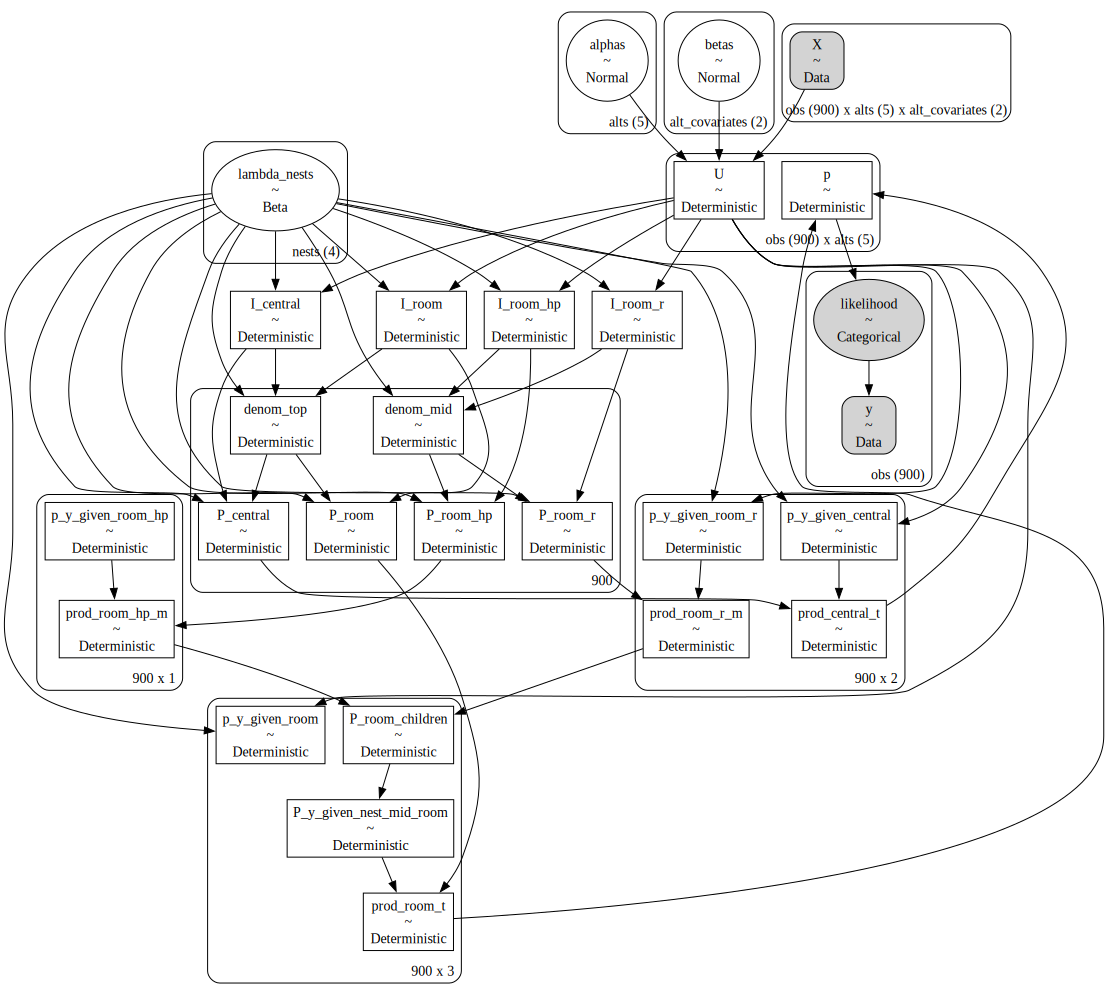

In [21]:
pm.model_to_graphviz(nstL_2.model)

In [22]:
nstL_2.sample(
    fit_kwargs={
        "target_accept": 0.97,
        "nuts_sampler": "numpyro",
        "idata_kwargs": {"log_likelihood": True},
    }
)

Sampling: [alphas, betas, lambda_nests, likelihood]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [likelihood]


Output()

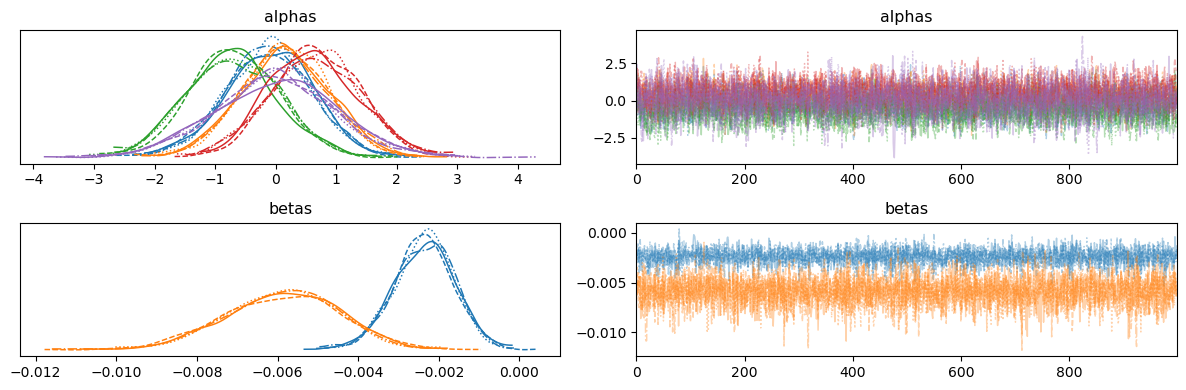

In [23]:
az.plot_trace(nstL_2.idata, var_names=["alphas", "betas"])
plt.tight_layout()

In [24]:
az.summary(nstL_2.idata, var_names=["betas", "alphas"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[ic],-0.002,0.001,-0.004,-0.001,0.000,0.000,3806.0,3176.0,1.0
betas[oc],-0.006,0.001,-0.009,-0.003,0.000,0.000,4074.0,2757.0,1.0
alphas[gc],-0.111,0.723,-1.418,1.309,0.015,0.012,2425.0,2359.0,1.0
alphas[ec],0.151,0.725,-1.220,1.502,0.014,0.012,2539.0,2378.0,1.0
alphas[gr],-0.708,0.750,-2.141,0.674,0.019,0.011,1541.0,2247.0,1.0
alphas[er],0.646,0.739,-0.759,2.003,0.019,0.011,1566.0,2149.0,1.0
alphas[hp],-0.009,1.003,-1.992,1.804,0.017,0.019,3505.0,2576.0,1.0


## Fixed Covariates

In [25]:
utility_formulas = [
    "gc ~ ic_gc + oc_gc | income + rooms ",
    "ec ~ ic_ec + oc_ec | income + rooms ",
    "gr ~ ic_gr + oc_gr | income + rooms",
    "er ~ ic_er + oc_er | income + rooms",
    "hp ~ ic_hp + oc_hp | income + rooms",
]

nesting_structure = {"central": ["gc", "ec"], "room": ["hp", "gr", "er"]}


nstL_3 = NestedLogit(
    df,
    utility_formulas,
    "depvar",
    covariates=["ic", "oc"],
    nesting_structure=nesting_structure,
)
nstL_3

In [26]:
nstL_3.sample()

Sampling: [alphas, betas, betas_fixed_, lambda_nests, likelihood]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [likelihood]


Output()

In [27]:
az.summary(nstL_3.idata, var_names=["alphas", "betas", "betas_fixed"])

/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alphas[gc],0.165,0.772,-1.362,1.536,0.015,0.011,2662.0,2440.0,1.0
alphas[ec],-0.198,0.772,-1.749,1.161,0.014,0.012,2852.0,2753.0,1.0
alphas[gr],0.558,0.380,-0.174,1.262,0.009,0.006,1987.0,2245.0,1.0
alphas[er],1.533,0.464,0.704,2.451,0.010,0.008,2188.0,2235.0,1.0
alphas[hp],-0.001,1.009,-1.979,1.812,0.016,0.017,4103.0,2849.0,1.0
betas[ic],-0.001,0.001,-0.003,-0.000,0.000,0.000,3709.0,3303.0,1.0
betas[oc],-0.006,0.001,-0.008,-0.003,0.000,0.000,2647.0,2908.0,1.0
"betas_fixed[gc, income]",-0.126,0.237,-0.587,0.180,0.008,0.009,1031.0,1237.0,1.0
"betas_fixed[gc, rooms]",-0.104,0.238,-0.570,0.225,0.009,0.012,1006.0,942.0,1.0
"betas_fixed[ec, income]",-0.124,0.244,-0.595,0.222,0.008,0.009,1114.0,1207.0,1.0


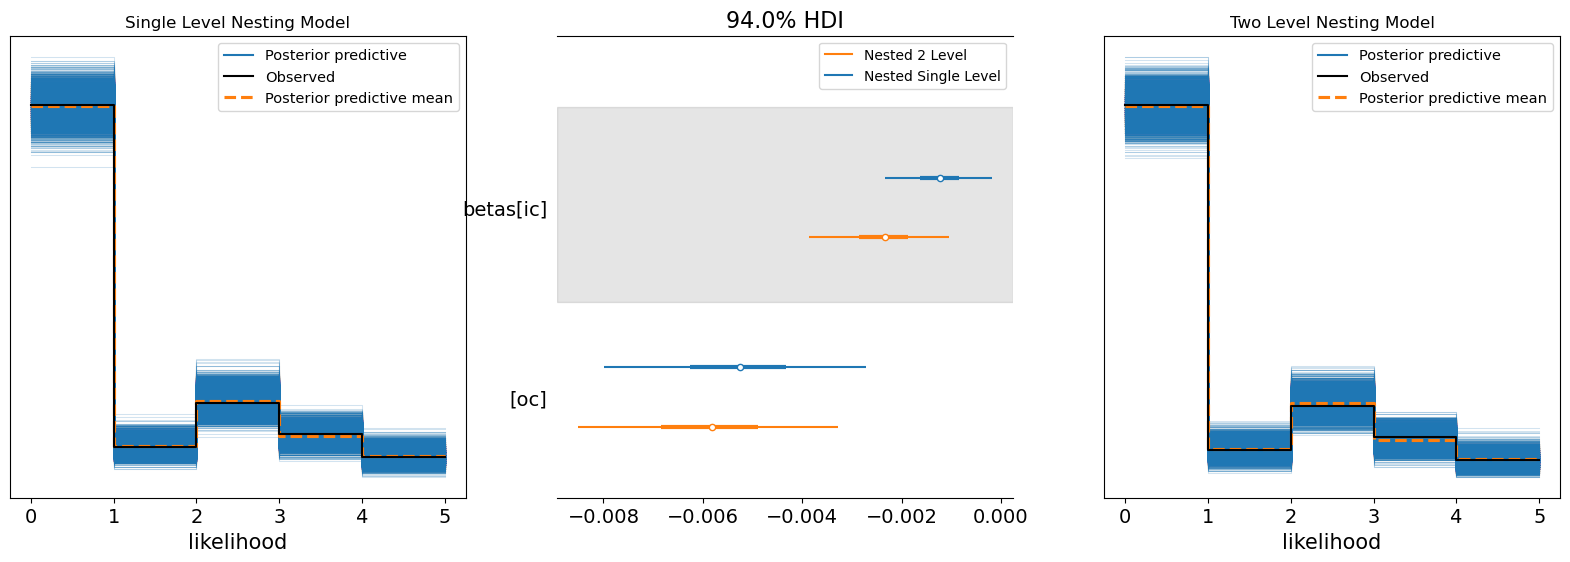

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs = axs.flatten()
az.plot_ppc(nstL_1.idata, ax=axs[0])
axs[0].set_title("Single Level Nesting Model")
az.plot_forest(
    [nstL_1.idata, nstL_2.idata],
    var_names=["betas"],
    combined=True,
    ax=axs[1],
    model_names=["Nested Single Level", "Nested 2 Level"],
)
axs[2].set_title("Two Level Nesting Model")
az.plot_ppc(nstL_2.idata, ax=axs[2]);

In [29]:
compare_df = az.compare(
    {
        "Single Level Nesting": nstL_1.idata,
        "Two Level Nesting": nstL_2.idata,
        "Single_Level Fixed Covariates": nstL_3.idata,
    }
)
compare_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Two Level Nesting,0,-1011.110875,6.096180,0.000000,0.878558,27.934584,0.00000,False,log
Single Level Nesting,1,-1013.437924,5.780455,2.327049,0.121442,27.888261,2.49202,False,log
Single_Level Fixed Covariates,2,-1018.157827,12.926676,7.046952,0.000000,28.161501,3.44493,False,log


## Making Interventions



In [30]:
new_policy_df = df.copy()
new_policy_df[["ic_ec", "ic_er"]] = new_policy_df[["ic_ec", "ic_er"]] * 1.5

idata_new_policy_1 = nstL_1.apply_intervention(new_choice_df=new_policy_df)
idata_new_policy_2 = nstL_2.apply_intervention(new_choice_df=new_policy_df)
idata_new_policy_3 = nstL_3.apply_intervention(new_choice_df=new_policy_df)
idata_new_policy_1

Sampling: [likelihood]


Output()

Sampling: [likelihood]


Output()

Sampling: [likelihood]


Output()

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [31]:
change_df_1 = nstL_1.calculate_share_change(nstL_1.idata, nstL_1.intervention_idata)
change_df_1

,policy_share,new_policy_share,relative_change
product,,,
gc,0.634470,0.662542,0.044244
ec,0.072123,0.040787,-0.434483
gr,0.147269,0.181622,0.233265
er,0.089814,0.045277,-0.495888
hp,0.056324,0.069773,0.238793


In [32]:
change_df_2 = nstL_2.calculate_share_change(nstL_2.idata, nstL_2.intervention_idata)
change_df_2

,policy_share,new_policy_share,relative_change
product,,,
gc,0.635316,0.677067,0.065717
ec,0.072606,0.023578,-0.675255
gr,0.148250,0.209428,0.412666
er,0.087489,0.031564,-0.639226
hp,0.056339,0.058363,0.035915


In [33]:
change_df_3 = nstL_3.calculate_share_change(nstL_3.idata, nstL_3.intervention_idata)
change_df_3

,policy_share,new_policy_share,relative_change
product,,,
gc,0.633803,0.660640,0.042343
ec,0.072252,0.040172,-0.443997
gr,0.146930,0.184647,0.256696
er,0.089741,0.042087,-0.531010
hp,0.057274,0.072454,0.265032


## Substitution Patterns

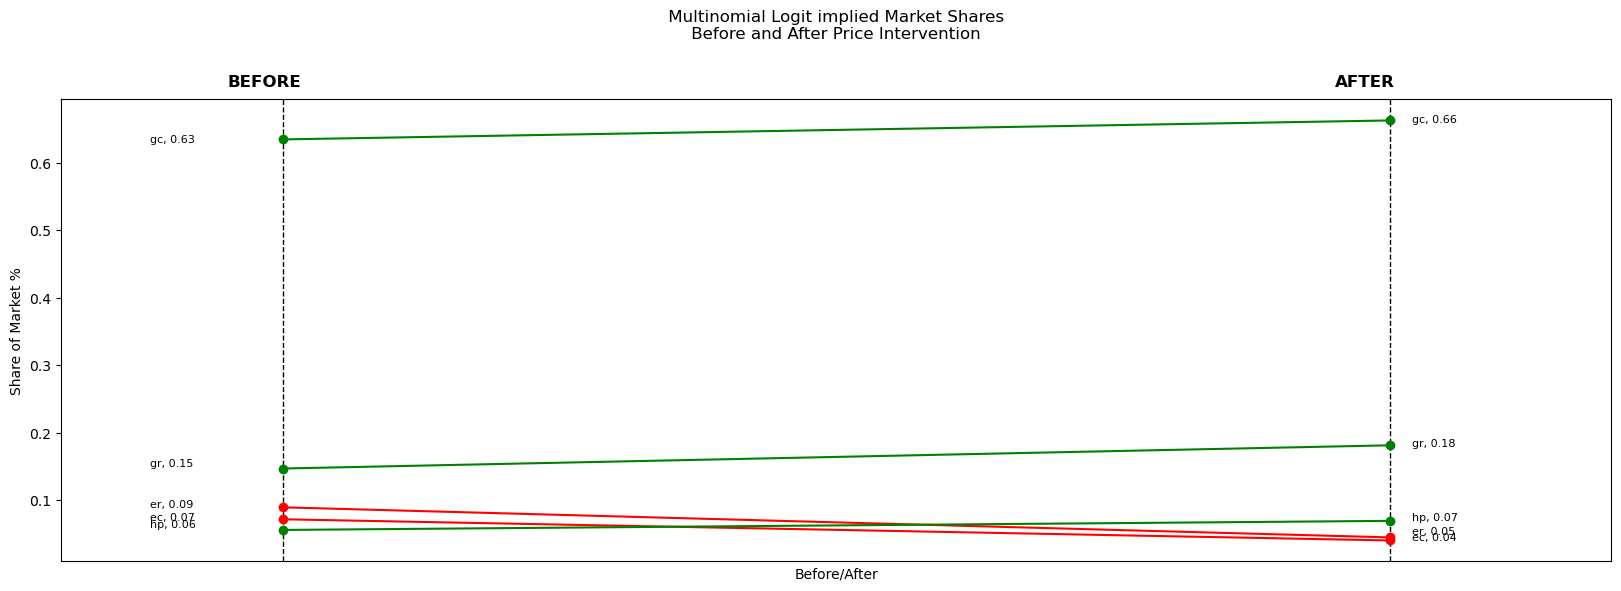

In [34]:
fig = nstL_1.make_change_plot(change_df=change_df_1, figsize=(20, 6))

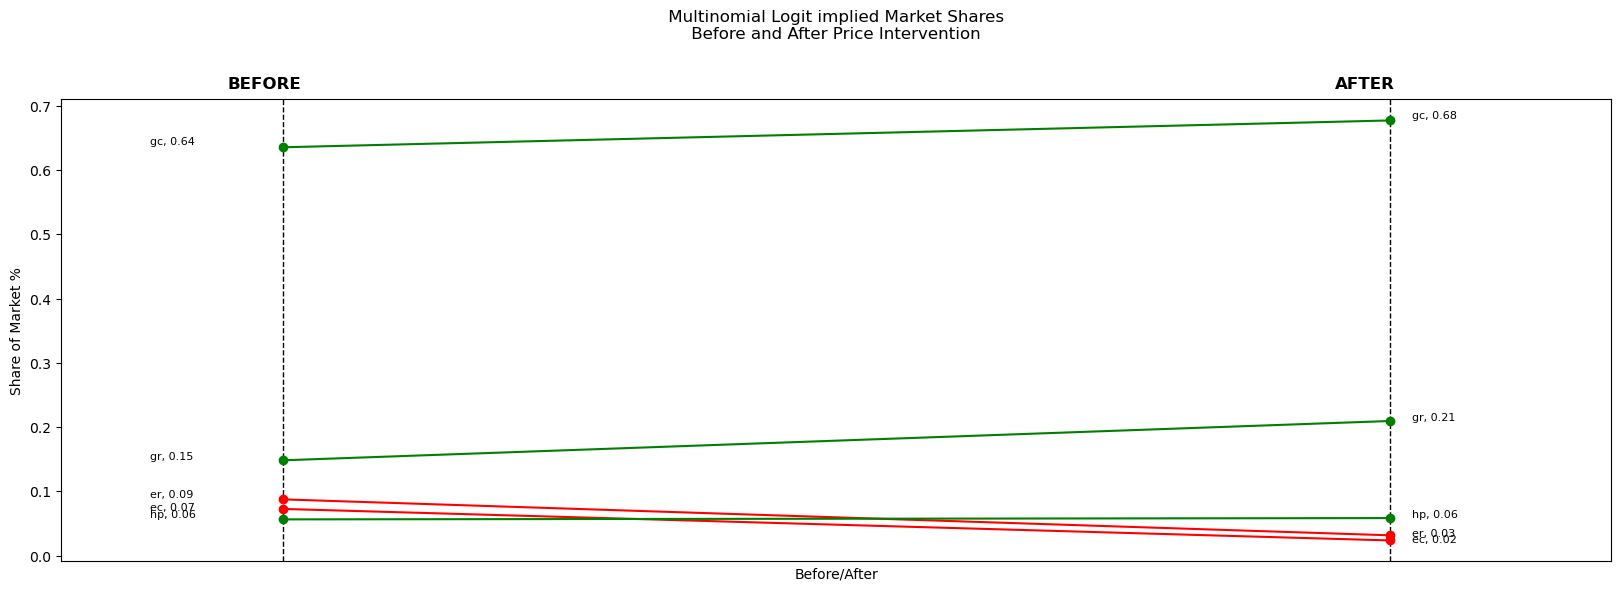

In [35]:
fig = nstL_2.make_change_plot(change_df=change_df_2, figsize=(20, 6))

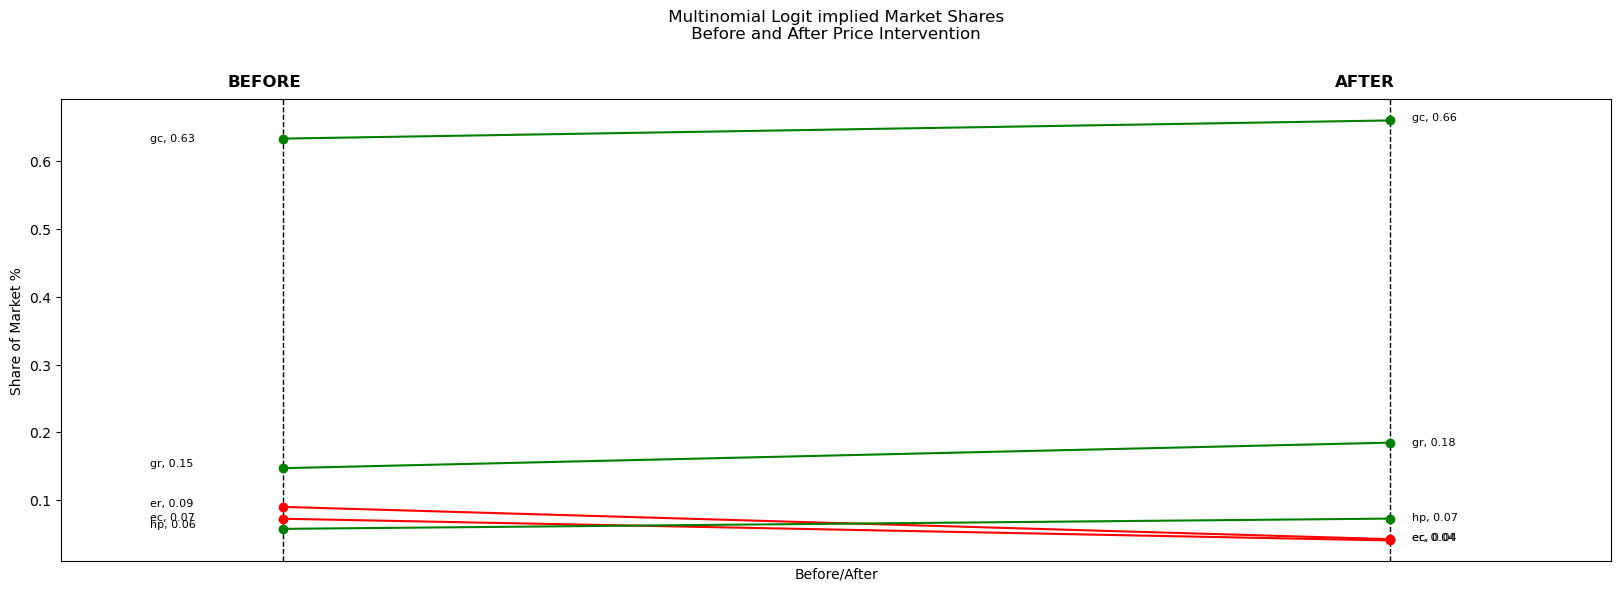

In [36]:
fig = nstL_3.make_change_plot(change_df=change_df_3, figsize=(20, 6))

In [37]:
compare_df = az.compare(
    {
        "Single Layer No Fixed": nstL_1.idata,
        "Two Layer No Fixed": nstL_2.idata,
        "Single Layer Fixed": nstL_3.idata,
    }
)
compare_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Two Layer No Fixed,0,-1011.110875,6.096180,0.000000,0.878558,27.934584,0.00000,False,log
Single Layer No Fixed,1,-1013.437924,5.780455,2.327049,0.121442,27.888261,2.49202,False,log
Single Layer Fixed,2,-1018.157827,12.926676,7.046952,0.000000,28.161501,3.44493,False,log


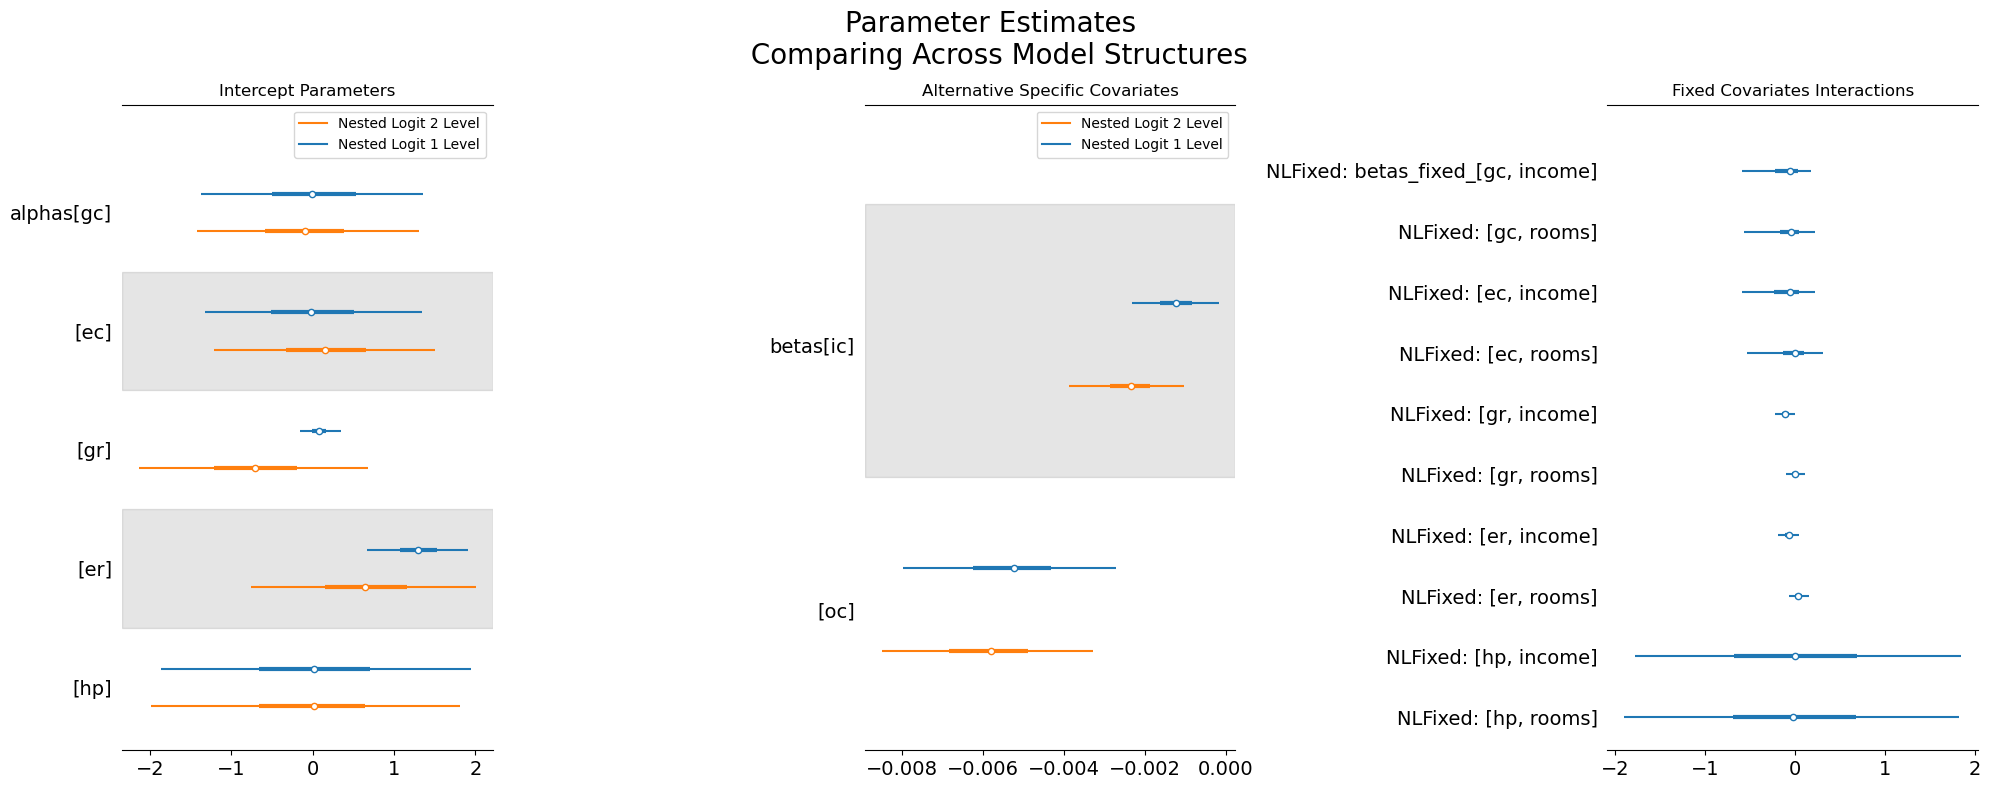

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs = axs.flatten()
az.plot_forest(
    [nstL_1.idata, nstL_2.idata],
    var_names=["alphas"],
    ax=axs[0],
    combined=True,
    model_names=["Nested Logit 1 Level", "Nested Logit 2 Level"],
)
az.plot_forest(
    [nstL_1.idata, nstL_2.idata],
    var_names=["betas"],
    ax=axs[1],
    combined=True,
    model_names=["Nested Logit 1 Level", "Nested Logit 2 Level"],
)
az.plot_forest(
    [nstL_3.idata],
    var_names=["betas_fixed_"],
    ax=axs[2],
    combined=True,
    model_names=["NLFixed"],
)
axs[0].set_title("Intercept Parameters")
axs[1].set_title("Alternative Specific Covariates")
axs[2].set_title("Fixed Covariates Interactions")
plt.suptitle("Parameter Estimates \n Comparing Across Model Structures", fontsize=20)
plt.tight_layout()

## Experimenting 

In [39]:
def make_exp_nest(U, W, betas_fixed_, lambdas_nests, nest, level="top"):
    """Calculate within nest probabilities.

    Allows mixing between levels of the nesting structure within the PyMC model.
    """
    N = U.shape[0]
    if "_" in nest:
        parent, child = nest.split("_")
    else:
        parent = None
    y_nest = U[:, nest_indices[level][nest]]
    if W is None:
        w_nest = pm.math.zeros((N, 5))
    else:
        betas_fixed_temp = betas_fixed_[nest_indices[level][nest], :]
        betas_fixed_temp = pm.Deterministic(
            f"beta_fixed_{level}_{nest}", pt.set_subtensor(betas_fixed_temp[-1, :], 0)
        )
        w_nest = pm.math.dot(W, betas_fixed_temp.T)

    if len(nest_indices[level][nest]) > 1:
        max_y_nest = pm.math.max(y_nest, axis=0)
        P_y_given_nest = pm.Deterministic(
            f"p_y_given_{nest}",
            pm.math.softmax(y_nest / lambdas_nests[lambda_lkup[nest]], axis=1),
        )
    else:
        max_y_nest = pm.math.max(y_nest)
        ones = pm.math.ones((N, 1))
        P_y_given_nest = pm.Deterministic(f"p_y_given_{nest}", ones)
    if parent is None:
        lambda_ = lambdas_nests[lambda_lkup[nest]]
        I_nest = pm.Deterministic(
            f"I_{nest}", pm.math.logsumexp((y_nest - max_y_nest) / lambda_)
        )
        W_nest = w_nest + I_nest * lambda_
    else:
        l1 = lambdas_nests[lambda_lkup[nest]]
        l2 = lambdas_nests[lambda_lkup[parent]]
        lambdas_ = l1 * l2
        I_nest = pm.Deterministic(
            f"I_{nest}", pm.math.logsumexp((y_nest - max_y_nest) / lambdas_)
        )
        W_nest = w_nest + I_nest * (lambdas_)

    exp_W_nest = pm.math.exp(W_nest)
    return exp_W_nest, P_y_given_nest


def make_P_nest(U, W, betas_fixed_, lambdas_nests, level):
    """Calculate the probability of choosing a nest."""
    conditional_probs = {}
    for n in nest_indices[level].keys():
        exp_W_nest, P_y_given_nest = make_exp_nest(
            U, W, betas_fixed_, lambdas_nests, n, level
        )
        if W is None:
            exp_W_nest = pm.math.sum(exp_W_nest, axis=1)
            conditional_probs[n] = {"exp": exp_W_nest, "P_y_given": P_y_given_nest}
        else:
            exp_W_nest = pm.math.sum(exp_W_nest, axis=1)
            conditional_probs[n] = {"exp": exp_W_nest, "P_y_given": P_y_given_nest}

    denom = pm.Deterministic(
        f"denom_{level}",
        pm.math.sum(
            [conditional_probs[n]["exp"] for n in nest_indices[level].keys()],
            axis=0,
        ),
    )
    nest_probs = {}
    for n in nest_indices[level].keys():
        P_nest = pm.Deterministic(f"P_{n}", (conditional_probs[n]["exp"] / denom))
        nest_probs[n] = P_nest
    return conditional_probs, nest_probs

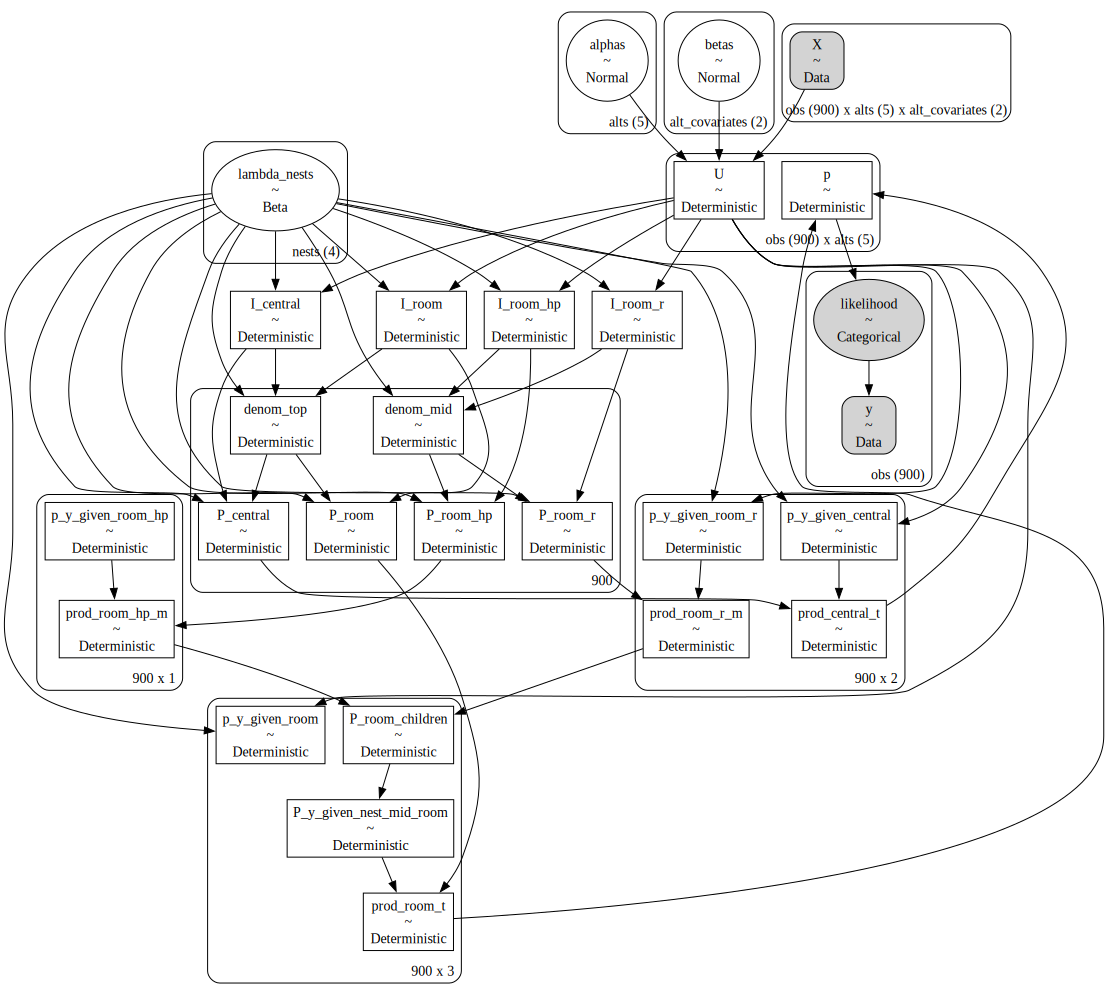

In [40]:
def build_model(X, W, y):
    """Build Model."""
    with pm.Model(coords=coords) as model:
        alphas = pm.Normal("alphas", 0, 1, dims="alts")
        betas = pm.Normal("betas", 0, 1, dims=("alt_covariates"))
        lambdas_nests = pm.Beta("lambda_nests", 2, 2, dims="nests")

        if W is None:
            w_nest = pm.math.zeros((len(coords["obs"]), len(alternatives)))
            betas_fixed_ = None
        else:
            W_data = pm.Data("W", W, dims=("obs", "fixed_covariates"))
            betas_fixed_ = pm.Normal(
                "betas_fixed_", 0, 1, dims=("alts", "fixed_covariates")
            )
            betas_fixed = pm.Deterministic(
                "betas_fixed",
                pt.set_subtensor(betas_fixed_[-1, :], 0),
                dims=("alts", "fixed_covariates"),
            )
            w_nest = pm.math.dot(W_data, betas_fixed.T)
        X_data = pm.Data("X", X, dims=("obs", "alts", "alt_covariates"))
        y_data = pm.Data("y", y, dims="obs")

        # Compute utility as a dot product
        alphas = pt.set_subtensor(alphas[-1], 0)
        u = alphas + pm.math.dot(X_data, betas)
        U = pm.Deterministic("U", w_nest + u, dims=("obs", "alts"))

        ## Mid Level
        if "mid" in nest_indices.keys():
            cond_prob_m, nest_prob_m = make_P_nest(
                U, W, betas_fixed_, lambdas_nests, "mid"
            )

            ## Construct Paths Bottom -> Up
            child_nests = {}
            path_prods_m: dict[str, list] = {}
            ordered = [(key, min(vals)) for key, vals in nest_indices["mid"].items()]
            middle_nests = [x[0] for x in sorted(ordered, key=lambda x: x[1])]
            for idx, n in enumerate(middle_nests):
                is_last = idx == len(middle_nests) - 1
                parent, child = n.split("_")
                P_nest = nest_prob_m[n]
                P_y_given_nest = cond_prob_m[n]["P_y_given"]
                prod = pm.Deterministic(
                    f"prod_{n}_m", (P_nest[:, pt.newaxis] * P_y_given_nest)
                )
                if parent in path_prods_m:
                    path_prods_m[parent].append(prod)
                else:
                    path_prods_m[parent] = []
                    path_prods_m[parent].append(prod)
                if is_last:
                    P_ = pm.Deterministic(
                        f"P_{parent}_children",
                        pm.math.concatenate(path_prods_m[parent], axis=1),
                    )
                    child_nests[parent] = P_
        else:
            child_nests = {}

        ## Top Level
        cond_prob_t, nest_prob_t = make_P_nest(U, W, betas_fixed_, lambdas_nests, "top")

        path_prods_t = []
        ordered = [(key, min(vals)) for key, vals in nest_indices["top"].items()]
        top_nests = [x[0] for x in sorted(ordered, key=lambda x: x[1])]
        for _idx, n in enumerate(top_nests):
            P_nest = nest_prob_t[n]
            P_y_given_nest = cond_prob_t[n]["P_y_given"]
            if n in child_nests:
                P_y_given_nest_mid = pm.Deterministic(
                    f"P_y_given_nest_mid_{n}", child_nests[n]
                )
                prod = pm.Deterministic(
                    f"prod_{n}_t", (P_nest[:, pt.newaxis] * (P_y_given_nest_mid))
                )
            else:
                prod = pm.Deterministic(
                    f"prod_{n}_t", (P_nest[:, pt.newaxis] * (P_y_given_nest))
                )
            path_prods_t.append(prod)
        P_ = pm.Deterministic(
            "p", pm.math.concatenate(path_prods_t, axis=1), dims=("obs", "alts")
        )

        _ = pm.Categorical("likelihood", p=P_, observed=y_data, dims="obs")

    return model


model = build_model(X=X, W=None, y=y)
pm.model_to_graphviz(model)